In [ ]:
using LinearAlgebra
using Random
using Printf

using SmoQyDQMC
import SmoQyDQMC.LatticeUtilities as latut
import SmoQyDQMC.JDQMCFramework    as dqmcf
import SmoQyDQMC.JDQMCMeasurements as dqmcm


function run_hubbard_chain_simulation(sID, U, μ, β, L, N_burnin, N_updates, N_bins; filepath = ".")
    datafolder_prefix = @sprintf "hubbard_chain_U%.2f_mu%.2f_L%d_b%.2f" U μ L β
    simulation_info = SimulationInfo(
        filepath = filepath,
        datafolder_prefix = datafolder_prefix,
        sID = sID
    )
    initialize_datafolder(simulation_info)

    seed = abs(rand(Int))
    rng = Xoshiro(seed)

    Δτ = 0.10

    # Calculate the length of the imaginary time axis, Lτ = β/Δτ.
    # The function  dqmcf.eval_length_imaginary_axis() simply ensures
    # that Lτ can be appropriately defined as an integer.
    Lτ = dqmcf.eval_length_imaginary_axis(β, Δτ)

    # This flag indicates whether or not to use the checkboard approximation to
    # represent the exponentiated hopping matrix exp(-Δτ⋅K)
    checkerboard = false

    # Whether the propagator matrices should be represented using the
    # symmetric form B = exp(-Δτ⋅K/2)⋅exp(-Δτ⋅V)⋅exp(-Δτ⋅K/2)
    # or the asymetric form B = exp(-Δτ⋅V)⋅exp(-Δτ⋅K)
    symmetric = false

    # Set the initial period in imaginary time slices with which the Green's function matrices
    # will be recomputed using a numerically stable procedure.
    n_stab = 10

    # Specify the maximum allowed error in any element of the Green's function matrix that is
    # corrected by performing numerical stabiliziation.
    δG_max = 1e-6

    # Calculate the bins size.
    # The bin size is the number of measurements that are averaged over each time data is written
    # to file during the simulation.
    bin_size = div(N_updates, N_bins)

    # Initialize a dictionary to store additional information about the simulation.
    # Thinks of this as a simulation notebook where you can store any parameters you would like to record
    # about how the DQMC simulation was run. For instance, it may be good to record the seed
    # used to initialize the random number generator for reproducibility reasons. This dictionary
    # will be appended as a table to the simulation information TOML file generated at the end of
    # the simulation.
    additional_info = Dict(
        "dG_max" => δG_max,
        "N_burnin" => N_burnin,
        "N_updates" => N_updates,
        "N_bins" => N_bins,
        "bin_size" => bin_size,
        "local_acceptance_rate" => 0.0,
        "n_stab_init" => n_stab,
        "symmetric" => symmetric,
        "checkerboard" => checkerboard,
        "seed" => seed,
    )

    #######################
    ### DEFINE THE MODEL ##
    #######################

    # Initialize an instance of the type UnitCell.
    # This struct defines the UnitCell.
    unit_cell = latut.UnitCell(lattice_vecs = [[1.0]],
                            basis_vecs   = [[0.0]])

    # Initialize an instance of the type Lattice.
    # The struct describes the size of the finite periodic lattice to be simulated.
    # Note that curretly periodic boundary condition must be used.
    lattice = latut.Lattice(
        L = [L],
        periodic = [true]
    )

    # Initialize an instance of the ModelGeometry type.
    # This type helps keep track of all the relevant features of the lattice
    # geometry being simulated, including the defintion of the unit cell,
    # the size of the finite periodic lattice, and all the relevant
    # bond defintions that may arise in the model.
    model_geometry = ModelGeometry(unit_cell, lattice)

    # Define the nearest-neighbor bond for a 1D chain.
    bond = latut.Bond(orbitals = (1,1), displacement = [1])

    # Add this bond to the model, by adding it to the ModelGeometry type.
    bond_id = add_bond!(model_geometry, bond)

    # Define nearest-neighbor hopping amplitude, setting the energy scale for the system.
    t = 1.0

    # Define the tight-binding model
    tight_binding_model = TightBindingModel(
        model_geometry = model_geometry,
        t_bonds = [bond], # defines hopping
        t_mean = [t],     # defines corresponding hopping amplitude
        μ = μ,            # set chemical potential
        ϵ_mean = [0.]     # set the (mean) on-site energy
    )

    # Initialize the Hubbard interaction in the model.
    hubbard_model = HubbardModel(
        shifted = false, # If true, Hubbard interaction instead parameterized as U⋅nup⋅ndn
        U_orbital = [1],
        U_mean = [U],
    )

    # Write the model summary to file.
    # The model summary file, "model_summary.toml", is a very important file.
    # It fully describes the model and system being simulated. It also defines all the
    # various tID definitions (ORBITAL_ID, BOND_ID, HOPPING_ID, PHONON_ID)
    # that measurements are reported in terms of. Therefore, this file is useful
    # for understanding out the interpret and process the output data files.
    model_summary(
        simulation_info = simulation_info,
        β = β, Δτ = Δτ,
        model_geometry = model_geometry,
        tight_binding_model = tight_binding_model,
        interactions = (hubbard_model,)
    )

    #########################################
    ### INITIALIZE FINITE MODEL PARAMETERS ##
    #########################################

    # Above we defined the both the model and lattice size. Next, we initialize
    # the actual system parameters. This is different because in general any
    # parameter appearing in the model can support disorder. For instance, you
    # can in simulate a system with random disorder in the on-site energy.
    # Therefore, we need to initialize the parameters for the model on the lattice
    # size we actually want to simulate.

    # Initialize tight-binding parameters.
    tight_binding_parameters = TightBindingParameters(
        tight_binding_model = tight_binding_model,
        model_geometry = model_geometry,
        rng = rng
    )

    # Initialize Hubbard interaction parameters.
    hubbard_parameters = HubbardParameters(
        model_geometry = model_geometry,
        hubbard_model = hubbard_model,
        rng = rng
    )

    # Apply Ising Hubbard-Stranonvich (HS) transformation, and initialize
    # corresponding HS fields that will be sampled in DQMC simulation.
    hubbard_ising_parameters = HubbardIsingHSParameters(
        β = β, Δτ = Δτ,
        hubbard_parameters = hubbard_parameters,
        rng = rng
    )

    ##############################
    ### INITIALIZE MEASUREMENTS ##
    ##############################

    # Here we initialize/define all the measurements we plan on making during the simulation.

    # Initialize the container that measurements will be accumulated into.
    measurement_container = initialize_measurement_container(model_geometry, β, Δτ)

    # Initialize the tight-binding model related measurements, like the hopping energy.
    initialize_measurements!(measurement_container, tight_binding_model)

    # Initialize the Hubbard interaction related measurements.
    initialize_measurements!(measurement_container, hubbard_model)

    # Initialize the single-particle electron Green's function measurement.
    # Because `time_displaced = true`, the time-displaced Greens function will be measured.
    initialize_correlation_measurements!(
        measurement_container = measurement_container,
        model_geometry = model_geometry,
        correlation = "greens",
        time_displaced = true,
        pairs = [(1, 1)]
    )

    # Initialize density correlation function measurement.
    # Because `time_displaced = false` and `integrated = true` the equal-time
    # density correlation function, and the charge susceptibility will
    # be measured. Note that the charge susceptibilty can be understood as the
    # integral of the time-displaced density correlation function over
    # the imaginary-time axis from τ=0 to τ=β.
    initialize_correlation_measurements!(
        measurement_container = measurement_container,
        model_geometry = model_geometry,
        correlation = "density",
        time_displaced = false,
        integrated = true,
        pairs = [(1, 1)]
    )

    # Initialize the pair correlation function measurement.
    # Measure the local s-wave equal-time pair correlation function (`time-displaced = false`),
    # and the corresponding pair susceptibility (`integrated = true`).
    initialize_correlation_measurements!(
        measurement_container = measurement_container,
        model_geometry = model_geometry,
        correlation = "pair",
        time_displaced = false,
        integrated = true,
        pairs = [(1, 1)]
    )

    # Initialize the spin-z correlation function measurement.
    initialize_correlation_measurements!(
        measurement_container = measurement_container,
        model_geometry = model_geometry,
        correlation = "spin_z",
        time_displaced = false,
        integrated = true,
        pairs = [(1, 1)]
    )

    # Initialize the sub-directories to which the various measurements will be written.
    initialize_measurement_directories(
        simulation_info = simulation_info,
        measurement_container = measurement_container
    )


    #############################
    ### SET-UP DQMC SIMULATION ##
    #############################

    # The code appearing in this section of the code is relatively boiler plate.
    # While it may change in some small ways from system to system, the overall
    # structure should remain relatively static.

    # Allocate FermionPathIntegral type for both the spin-up and spin-down electrons.
    fermion_path_integral_up = FermionPathIntegral(tight_binding_parameters = tight_binding_parameters, β = β, Δτ = Δτ)
    fermion_path_integral_dn = FermionPathIntegral(tight_binding_parameters = tight_binding_parameters, β = β, Δτ = Δτ)

    # Initialize the FermionPathIntegral type for both the spin-up and spin-down electrons.
    initialize!(fermion_path_integral_up, fermion_path_integral_dn, hubbard_parameters)
    initialize!(fermion_path_integral_up, fermion_path_integral_dn, hubbard_ising_parameters)

    # Initialize the imaginary-time propagators for each imaginary-time slice for both the
    # spin-up and spin-down electrons.
    Bup = initialize_propagators(fermion_path_integral_up, symmetric=symmetric, checkerboard=checkerboard)
    Bdn = initialize_propagators(fermion_path_integral_dn, symmetric=symmetric, checkerboard=checkerboard)

    # Initialize FermionGreensCalculator for the spin-up and spin-down electrons.
    fermion_greens_calculator_up = dqmcf.FermionGreensCalculator(Bup, β, Δτ, n_stab)
    fermion_greens_calculator_dn = dqmcf.FermionGreensCalculator(Bdn, β, Δτ, n_stab)

    # Allcoate matrices for spin-up and spin-down electron Green's function matrices.
    Gup = zeros(eltype(Bup[1]), size(Bup[1]))
    Gdn = zeros(eltype(Bdn[1]), size(Bdn[1]))

    # Initialize the spin-up and spin-down electron Green's function matrices, also
    # calculating their respective determinants as the same time.
    logdetGup, sgndetGup = dqmcf.calculate_equaltime_greens!(Gup, fermion_greens_calculator_up)
    logdetGdn, sgndetGdn = dqmcf.calculate_equaltime_greens!(Gdn, fermion_greens_calculator_dn)

    # Allocate matrices for various time-displaced Green's function matrices.
    Gup_ττ = similar(Gup) # G↑(τ,τ)
    Gup_τ0 = similar(Gup) # G↑(τ,0)
    Gup_0τ = similar(Gup) # G↑(0,τ)
    Gdn_ττ = similar(Gdn) # G↓(τ,τ)
    Gdn_τ0 = similar(Gdn) # G↓(τ,0)
    Gdn_0τ = similar(Gdn) # G↓(0,τ)

    # Initialize variables to keep track of the largest numerical error in the
    # Green's function matrices corrected by numerical stabalization.
    δG = zero(typeof(logdetGup))
    δθ = zero(typeof(sgndetGup))

    ####################################
    ### BURNIN/THERMALIZATION UPDATES ##
    ####################################

    # Iterate over burnin/thermalization updates.
    for n in 1:N_burnin

        # Perform a sweep through the lattice, attemping an update to each Ising HS field.
        (acceptance_rate, logdetGup, sgndetGup, logdetGdn, sgndetGdn, δG, δθ) = local_updates!(
            Gup, logdetGup, sgndetGup, Gdn, logdetGdn, sgndetGdn,
            hubbard_ising_parameters,
            fermion_path_integral_up = fermion_path_integral_up,
            fermion_path_integral_dn = fermion_path_integral_dn,
            fermion_greens_calculator_up = fermion_greens_calculator_up,
            fermion_greens_calculator_dn = fermion_greens_calculator_dn,
            Bup = Bup, Bdn = Bdn, δG_max = δG_max, δG = δG, δθ = δθ, rng = rng
        )

        # Record the acceptance rate for the attempted local updates to the HS fields.
        additional_info["local_acceptance_rate"] += acceptance_rate
    end

    ################################
    ### START MAKING MEAUSREMENTS ##
    ################################

    # Re-initialize variables to keep track of the largest numerical error in the
    # Green's function matrices corrected by numerical stabalization.
    δG = zero(typeof(logdetGup))
    δθ = zero(typeof(sgndetGup))

    # Iterate over the number of bin, i.e. the number of time measurements will be dumped to file.
    for bin in 1:N_bins

        # Iterate over the number of updates and measurements performed in the current bin.
        for n in 1:bin_size

            # Perform a sweep through the lattice, attemping an update to each Ising HS field.
            (acceptance_rate, logdetGup, sgndetGup, logdetGdn, sgndetGdn, δG, δθ) = local_updates!(
                Gup, logdetGup, sgndetGup, Gdn, logdetGdn, sgndetGdn,
                hubbard_ising_parameters,
                fermion_path_integral_up = fermion_path_integral_up,
                fermion_path_integral_dn = fermion_path_integral_dn,
                fermion_greens_calculator_up = fermion_greens_calculator_up,
                fermion_greens_calculator_dn = fermion_greens_calculator_dn,
                Bup = Bup, Bdn = Bdn, δG_max = δG_max, δG = δG, δθ = δθ, rng = rng
            )

            # Record the acceptance rate for the attempted local updates to the HS fields.
            additional_info["local_acceptance_rate"] += acceptance_rate

            # Make measurements, with the results being added to the measurement container.
            (logdetGup, sgndetGup, logdetGdn, sgndetGdn, δG, δθ) = make_measurements!(
                measurement_container,
                logdetGup, sgndetGup, Gup, Gup_ττ, Gup_τ0, Gup_0τ,
                logdetGdn, sgndetGdn, Gdn, Gdn_ττ, Gdn_τ0, Gdn_0τ,
                fermion_path_integral_up = fermion_path_integral_up,
                fermion_path_integral_dn = fermion_path_integral_dn,
                fermion_greens_calculator_up = fermion_greens_calculator_up,
                fermion_greens_calculator_dn = fermion_greens_calculator_dn,
                Bup = Bup, Bdn = Bdn, δG_max = δG_max, δG = δG, δθ = δθ,
                model_geometry = model_geometry, tight_binding_parameters = tight_binding_parameters,
                coupling_parameters = (hubbard_parameters, hubbard_ising_parameters)
            )
        end

        # Write the average measurements for the current bin to file.
        write_measurements!(
            measurement_container = measurement_container,
            simulation_info = simulation_info,
            model_geometry = model_geometry,
            bin = bin,
            bin_size = bin_size,
            Δτ = Δτ
        )
    end

    # Calculate acceptance rate for local updates.
    additional_info["local_acceptance_rate"] /= (N_updates + N_burnin)

    # Record the final numerical stabilization period that the simulation settled on.
    additional_info["n_stab_final"] = fermion_greens_calculator_up.n_stab

    # Record the maximum numerical error corrected by numerical stablization.
    additional_info["dG"] = δG

    # Write simulation summary TOML file.
    # This simulation summary file records the version number of SmoQyDQMC and Julia
    # used to perform the simulation. The dictionary `additional_info` is appended
    # as a table to the end of the simulation summary TOML file.
    save_simulation_info(simulation_info, additional_info)

    #################################
    ### PROCESS SIMULATION RESULTS ##
    #################################

   # Note that everyting appearing in this section of the code is considered post-processing,
   # and can be re-run so long as the data folder generated by the DQMC simulation persists
   # and none of the binned data has been deleted from it.

    # Process the simulation results, calculating final error bars for all measurements,
    # writing final statisitics to CSV files.
    process_measurements(simulation_info.datafolder, N_bins)

    return nothing
end


sID::Int = 1
U::Float64 = 1
μ::Float64 = 0.5
β::Float64 = 2
L::Int = 4
N_burnin::Int = 2000
N_updates::Int = 5000
N_bins::Int = 1
run_hubbard_chain_simulation(sID, U, μ, β, L, N_burnin, N_updates, N_bins; filepath=raw"D:\datasets\dqmc_hubbard")

In [ ]:
# import Pkg; Pkg.add("JLD2")
using JLD2

path = raw"C:\Users\jonat\OneDrive - Cornell University\programming\cornell courses\solid state physics I\final_project\hubbard_chain_U-5.00_mu0.00_L8_b100.00-1\equal-time\density\position\bin-1_pID-0.jld2"
data = load(path)


Dict{String, Any} with 3 entries:
  "id_pairs"       => [(1, 1)]
  "correlations"   => Vector{ComplexF64}[[1.85514+0.0im, 0.543972+0.0im, 1.1308…
  "time_displaced" => false

# Square lattice

sh C:\Users\jonat\.julia\bin\mpiexecjl -n 8 julia dqmc.jl 1 -4 0.0 10 8 2000 10000 50

In [ ]:
using CSV
using DataFrames
using TOML
using Plots
using LaTeXStrings

beta = []
Ps = []
path = raw"C:\Users\jonat\OneDrive - Cornell University\programming\cornell courses\solid state physics I\final_project"
for dir in readdir(path)
    # println(dir)
    if occursin("hubbard_square", dir) && occursin("L8", dir)
        datapath = joinpath(path,dir, raw"equal-time\pair\pair_position_equal-time_stats.csv")
        meta_data = TOML.parsefile(joinpath(path, dir, "model_summary.toml"))
        df = CSV.read(datapath, DataFrame; delim=" ")
        push!(Ps, sum(df[!, "MEAN_R"][2:end]))
        push!(beta, meta_data["beta"])
        # println(meta_data["beta"])
    end
end
# datapath = joinpath(path, raw"equal-time\density\density_momentum_equal-time_stats.csv")
# meta_data = TOML.parsefile(joinpath(path, "model_summary.toml"))
# df = CSV.read(datapath, DataFrame; delim=" ")


correlation.pdf
dispersion_relation.ipynb
dqmc.jl
hubbard_chain_U-5.00_mu0.00_L8_b10.00-1
hubbard_chain_U-5.00_mu0.00_L8_b100.00-1
hubbard_chain_U-8.00_mu0.00_L16_b1.00-1
hubbard_chain_U5.00_mu0.00_L8_b10.00-1
hubbard_square_U-4.00_mu0.00_L2_b10.00-1
hubbard_square_U-4.00_mu0.00_L4_b1.00-1
hubbard_square_U-4.00_mu0.00_L8_b0.05-1
0.05
hubbard_square_U-4.00_mu0.00_L8_b0.30-1
0.3
hubbard_square_U-4.00_mu0.00_L8_b0.50-1
0.5
hubbard_square_U-4.00_mu0.00_L8_b1.00-1
1.0
hubbard_square_U-4.00_mu0.00_L8_b10.00-1
10.0
hubbard_square_U-4.00_mu0.00_L8_b2.00-1
2.0
hubbard_square_U-4.00_mu0.00_L8_b3.00-1
3.0
k_occupation.pdf
superconductivity_dqmc.ipynb
superconductivity_ed.ipynb


In [ ]:
using Plots

i = sortperm(beta)
plot(beta[i], Ps[i], legend=false)
scatter!(beta[i], Ps[i], legend=false,c="black")
ylabel!(L"P_s")
xlabel!(L"\beta")
# xlims!(0,3.1)
# ylims!(0,1.2)
# savefig("transition.pdf")

"c:\\Users\\jonat\\OneDrive - Cornell University\\programming\\cornell courses\\solid state physics I\\final_project\\transition.pdf"

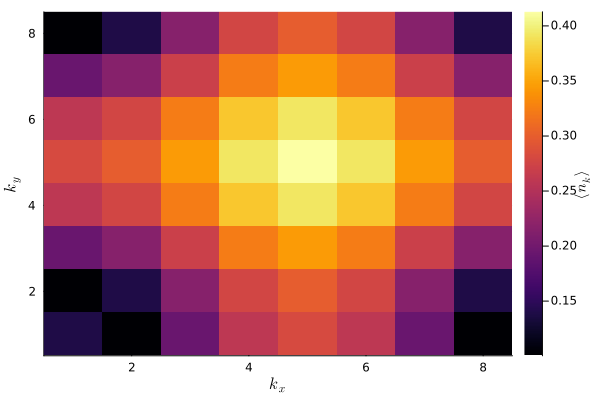

In [52]:
using CSV
using DataFrames
using TOML
using Plots

path = raw"C:\Users\jonat\OneDrive - Cornell University\programming\cornell courses\solid state physics I\final_project\hubbard_square_U4.00_mu0.00_L8_b3.00-1"
datapath = joinpath(path, raw"equal-time\density\density_momentum_equal-time_stats.csv")
meta_data = TOML.parsefile(joinpath(path, "model_summary.toml"))
df = CSV.read(datapath, DataFrame; delim=" ")

occupation = zeros(meta_data["Geometry"]["Lattice"]["L"]...)
for row in eachrow(df)
    occupation[row["K_1"]+1, row["K_2"]+1] = row["MEAN_R"]
end
occupation[1,1] = occupation[end,end] 

# fig = Figure()
heatmap(1:meta_data["Geometry"]["Lattice"]["L"][1],1:meta_data["Geometry"]["Lattice"]["L"][2],occupation, colorbar_title=L"\langle n_{k}\rangle")
xlabel!(L"k_x")
ylabel!(L"k_y")
# savefig("beta=3_brillouin_zone.pdf")